In [1]:
"""
In this exercise we will train some neural network using Pytorch.
Installation instructions: https://pytorch.org/get-started/locally/

I recommend to run this exercise in colab using GPU or in kaggle notebooks.
You should find something like: Runtime -> Change runtime type -> T4 GPU to access GPU there.
Everything thing you need is preinstalled there.
"""

'\nIn this exercise we will train some neural network using Pytorch.\nInstallation instructions: https://pytorch.org/get-started/locally/\n\nI recommend to run this exercise in colab using GPU or in kaggle notebooks.\n'

In [2]:
# Because outside world is ugly
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [3]:
# Pytorch is library for dealing with neural networks (and automatic gradients)
import torch
import torch.nn as nn
import torch.nn.functional as F
# Torchvision is helper library for pytorch to deal with computer vision
import torchvision

import matplotlib.pyplot as plt

In [4]:
"""Prepare dataset, whole lecture will be done over MNIST dataset"""
batch_size_train = 256
batch_size_test = 1024

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

/home/usamec/anaconda3/envs/magic_train/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630815121/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
# What is in train?
for x, y in train_loader:
    print(x.shape, y.shape, y[:10])
    break

torch.Size([256, 1, 28, 28]) torch.Size([256]) tensor([1, 4, 0, 8, 7, 7, 2, 9, 2, 1])


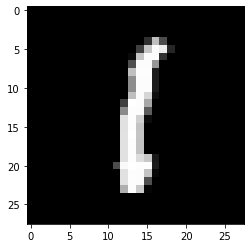

In [6]:
# X: 256 images, 1 channel (black/white), 28x28 image
# We will flatten each image into one vector for now
# Y: One number (category of image)
# Images looks like this:

plt.imshow(x[0,0], cmap="gray")

In [7]:
# Simple linear model from last lecture
# This just computes scores for each class
model_linear = nn.Linear(28*28, 10)
[(name, p.shape) for name, p in model_linear.named_parameters()]

[('weight', torch.Size([10, 784])), ('bias', torch.Size([10]))]

In [8]:
# Let's compute loss for one batch of images
output = model_linear(x.flatten(1))
log_probs = F.log_softmax(output, dim=-1)    # log_softmax(.) = log(softmax(.))
loss = F.nll_loss(log_probs, y)
loss

tensor(2.4573, grad_fn=<NllLossBackward>)

In [9]:
# Pytorch has many loss functions, which look similar but take different things,
# so take care
# Here cross entropy(output, y) is same as nll_loss(log_softmax(output), y)
loss2 = F.cross_entropy(output, y)
loss2

tensor(2.4573, grad_fn=<NllLossBackward>)

In [10]:
# If we want to train model, we need to get gradients
# This is easy, gradient will magically appear
loss.backward()
model_linear.weight.grad

# If you really want to do things by hand
# model_linear.weight.data = model_linear.weight.data - 0.01 * model_linear.weight.grad

tensor([[ 0.0013,  0.0013,  0.0013,  ...,  0.0013,  0.0013,  0.0013],
        [ 0.0209,  0.0209,  0.0209,  ...,  0.0209,  0.0209,  0.0209],
        [ 0.0345,  0.0345,  0.0345,  ...,  0.0345,  0.0345,  0.0345],
        ...,
        [-0.0437, -0.0437, -0.0437,  ..., -0.0437, -0.0437, -0.0437],
        [ 0.0108,  0.0108,  0.0108,  ...,  0.0108,  0.0108,  0.0108],
        [-0.0161, -0.0161, -0.0161,  ..., -0.0161, -0.0161, -0.0161]])

In [11]:
# If we calculate gradient second time, it will accumulate
output = model_linear(x.flatten(1))
log_probs = F.log_softmax(output, dim=-1)    # log_softmax(.) = log(softmax(.))
loss = F.nll_loss(log_probs, y)
loss.backward()
model_linear.weight.grad

tensor([[ 0.0026,  0.0026,  0.0026,  ...,  0.0026,  0.0026,  0.0026],
        [ 0.0418,  0.0418,  0.0418,  ...,  0.0418,  0.0418,  0.0418],
        [ 0.0690,  0.0690,  0.0690,  ...,  0.0690,  0.0690,  0.0690],
        ...,
        [-0.0875, -0.0875, -0.0875,  ..., -0.0875, -0.0875, -0.0875],
        [ 0.0217,  0.0217,  0.0217,  ...,  0.0217,  0.0217,  0.0217],
        [-0.0322, -0.0322, -0.0322,  ..., -0.0322, -0.0322, -0.0322]])

In [12]:
# Lets optimize, this is typical pytorch training loop you will see a lot with some modifications
model_linear = nn.Linear(28*28, 10)
optimizer = torch.optim.SGD(model_linear.parameters(), lr=1)

for epoch in range(5):
    total_loss = 0
    total_loss_cc = 0
    for x, y in train_loader:
        # Here we calculate output from the model, note that we flatten the input (converts 256,1,28,28 to 256,784) 
        output = model_linear(x.flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        # Here we calculate loss
        batch_loss = F.nll_loss(log_probs, y)
        # Here we calculate gradients, first we need to zero previous ones
        optimizer.zero_grad()
        batch_loss.backward()
        # And here we update the weights
        optimizer.step()
        total_loss += batch_loss.item()
        total_loss_cc += 1
    print("epoch", epoch, "training loss", total_loss / total_loss_cc)

epoch 0 training loss 2.007697594799894
epoch 1 training loss 1.245814481187374
epoch 2 training loss 1.1943411404782154
epoch 3 training loss 1.0507514679685552
epoch 4 training loss 1.121161828015713


In [13]:
# Optimize and compute training accuracy and test accuracy

model_linear = nn.Linear(28*28, 10)
optimizer = torch.optim.SGD(model_linear.parameters(), lr=1)

for epoch in range(10):
    total_loss = 0
    total_loss_cc = 0
    total_good = 0
    total_samples = 0
    
    for x, y in train_loader:
        output = model_linear(x.flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        
        # This calulcates accuracy
        prediction = log_probs.argmax(dim=-1)
        total_good += (prediction == y).sum().item()
        total_samples += y.shape[0]
        
        batch_loss = F.nll_loss(log_probs, y)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()
        total_loss_cc += 1
        
    total_good_test = 0
    total_samples_test = 0
    for x, y in test_loader:
        output = model_linear(x.flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good_test += (prediction == y).sum().item()
        total_samples_test += y.shape[0]
        
    print("epoch", epoch, "training loss %.3f" % (total_loss / total_loss_cc), 
          "training accuracy %.3f" % (total_good / total_samples), 
          "testing accuracy %.3f" % (total_good_test / total_samples_test))

epoch 0 training loss 2.043 training accuracy 0.834 testing accuracy 0.886
epoch 1 training loss 1.231 training accuracy 0.870 testing accuracy 0.720
epoch 2 training loss 1.239 training accuracy 0.875 testing accuracy 0.576
epoch 3 training loss 1.169 training accuracy 0.878 testing accuracy 0.904
epoch 4 training loss 1.019 training accuracy 0.885 testing accuracy 0.818
epoch 5 training loss 1.104 training accuracy 0.883 testing accuracy 0.889
epoch 6 training loss 1.073 training accuracy 0.882 testing accuracy 0.744
epoch 7 training loss 1.062 training accuracy 0.885 testing accuracy 0.879
epoch 8 training loss 1.033 training accuracy 0.887 testing accuracy 0.844
epoch 9 training loss 1.081 training accuracy 0.885 testing accuracy 0.841


In [14]:
# Let's train neural network, we only change model and maybe learning rate

model = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)
optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.0)

for epoch in range(10):
    total_loss = 0
    total_loss_cc = 0
    total_good = 0
    total_samples = 0
    
    for x, y in train_loader:
        output = model(x.flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good += (prediction == y).sum().item()
        total_samples += y.shape[0]
        
        batch_loss = F.nll_loss(log_probs, y)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()
        total_loss_cc += 1
        
    total_good_test = 0
    total_samples_test = 0
    for x, y in test_loader:
        output = model(x.flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good_test += (prediction == y).sum().item()
        total_samples_test += y.shape[0]
        
    print("epoch", epoch, "training loss %.3f" % (total_loss / total_loss_cc), 
          "training accuracy %.3f" % (total_good / total_samples), 
          "testing accuracy %.3f" % (total_good_test / total_samples_test))

epoch 0 training loss 1.582 training accuracy 0.535 testing accuracy 0.647
epoch 1 training loss 0.743 training accuracy 0.783 testing accuracy 0.888
epoch 2 training loss 0.423 training accuracy 0.888 testing accuracy 0.876
epoch 3 training loss 0.305 training accuracy 0.917 testing accuracy 0.868
epoch 4 training loss 0.273 training accuracy 0.924 testing accuracy 0.919
epoch 5 training loss 0.286 training accuracy 0.916 testing accuracy 0.855
epoch 6 training loss 0.261 training accuracy 0.927 testing accuracy 0.933
epoch 7 training loss 0.210 training accuracy 0.940 testing accuracy 0.922
epoch 8 training loss 0.193 training accuracy 0.944 testing accuracy 0.925
epoch 9 training loss 0.173 training accuracy 0.949 testing accuracy 0.939


In [15]:
"""
# How to run on cuda (this optional, if you have GPU access, vyuka does not have one, colab does)
# No need to run this cell

model = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)
# Move model to GPU. Instead of x.cuda() you can also use x.to(device) where device is "cpu" or "cuda" so your code
# is nicely parametrized.

model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for epoch in range(10):
    total_loss = 0
    total_loss_cc = 0
    total_good = 0
    total_samples = 0
    
    for x, y in train_loader:
        # Move input and labels to GPU
        output = model(x.cuda().flatten(1))
        y = y.cuda()
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good += (prediction == y).sum().item()
        total_samples += y.shape[0]
        
        batch_loss = F.nll_loss(log_probs, y)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()
        total_loss_cc += 1
        
    total_good_test = 0
    total_samples_test = 0
    for x, y in test_loader:
        # Move input and labels to GPU
        y = y.cuda()
        output = model(x.cuda().flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good_test += (prediction == y).sum().item()
        total_samples_test += y.shape[0]
        
    print("epoch", epoch, "training loss %.3f" % (total_loss / total_loss_cc), 
          "training accuracy %.3f" % (total_good / total_samples), 
          "testing accuracy %.3f" % (total_good_test / total_samples_test))
          
"""

'\n# How to run on cuda (this optional, if you have GPU access, vyuka does not have one, colab does)\n# No need to run this cell\n\nmodel = nn.Sequential(\n    nn.Linear(28*28, 256),\n    nn.ReLU(),\n    nn.Linear(256, 10)\n)\n# Move model to GPU. Instead of x.cuda() you can also use x.to(device) where device is "cpu" or "cuda" so your code\n# is nicely parametrized.\n\nmodel.cuda()\noptimizer = torch.optim.SGD(model.parameters(), lr=0.1)\n\nfor epoch in range(20):\n    total_loss = 0\n    total_loss_cc = 0\n    total_good = 0\n    total_samples = 0\n    \n    for x, y in train_loader:\n        # Move input and labels to GPU\n        output = model(x.cuda().flatten(1))\n        y = y.cuda()\n        log_probs = F.log_softmax(output, dim=-1)\n        \n        prediction = log_probs.argmax(dim=-1)\n        total_good += (prediction == y).sum().item()\n        total_samples += y.shape[0]\n        \n        batch_loss = F.nll_loss(log_probs, y)\n        optimizer.zero_grad()\n        batc

In [16]:
"""
Task 1.
In example above figure out best settings for learning rate a momentum in the optimizer.
Keep the number of epochs to 10. Also keep the learning constant during training.
Sumarize your findings in some chart or table.
"""

'\nTask 1.\nIn example above figure out best settings for learning rate a momentum in the optimizer.\nKeep the number of epochs to 10. Also keep the learning constant during training.\nSumarize your findings in some chart or table.\n'

In [17]:
"""
Task 2.
Here is network with 2 hidden layers (each additional hidden layer we add nn.Linear(256,256) and nn.ReLU())

model = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

How does adding more hidden layers influence final accuracy (try 3-6 hidden layers).
Always figure out the best optimizer settings. Again run for 10 epochs.
Again produce some chart or table.
"""

'\nTask 2.\nHere is network with 2 hidden layers (each additional hidden layer we add nn.Linear(256,256) and nn.ReLU())\n\nmodel = nn.Sequential(\n    nn.Linear(28*28, 256),\n    nn.ReLU(),\n    nn.Linear(256, 256),\n    nn.ReLU(),\n    nn.Linear(256, 10)\n)\n\nHow does adding more hidden layers influence final accuracy (try 3-6 hidden layers).\nAlways figure out the best optimizer settings. Again run for 10 epochs.\nAgain produce some chart or table.\n'

In [18]:
"""
Task 3.
Here is an example of convolutional network. Do not change it for this task.
Only figure out best settings for the optimizer. Also run for only 10 epochs.
model = nn.Sequential(
    nn.Conv2d(1, 16, 5, padding=1, stride=2),  # Here we get 14x14 image with 16 channels
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, padding='same'),
    nn.ReLU(),
    nn.Conv2d(16, 32, 3, padding=1, stride=2),  # Here we get 7x7 image with 32 channels
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, padding='same'),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(7*7*32, 10)
)

Run training of convolutional network and report the results and compare with best results from above.
Also, there is no need to flatten the input now. 
"""

"\nTask 3.\nHere is an example of convolutional network. Do not change it for this task.\nOnly figure out best settings for the optimizer. Also run for only 10 epochs.\nmodel = nn.Sequential(\n    nn.Conv2d(1, 16, 5, padding=1, stride=2),  # Here we get 14x14 image with 16 channels\n    nn.ReLU(),\n    nn.Conv2d(16, 16, 3, padding='same'),\n    nn.ReLU(),\n    nn.Conv2d(16, 32, 3, padding=1, stride=2),  # Here we get 7x7 image with 32 channels\n    nn.ReLU(),\n    nn.Conv2d(32, 32, 3, padding='same'),\n    nn.ReLU(),\n    nn.Flatten(),\n    nn.Linear(7*7*32, 10)\n)\n\nRun training of convolutional network and report the results and compare with best results from above.\nAlso, there is no need to flatten the input now. \n"

In [19]:
"""
Task 4 bonus:
Change neural architecture like you want and achive best accuracy in 10 epochs.
"""

'\nTask 4 bonus:\nChange neural architecture like you want and achive best accuracy in 10 epochs.\n'